In [64]:
# resources 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import scipy.stats as stats
import warnings

# collect data
from bcb import sgs

# modeling series 
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsforecast.arima import arima_string

# ploting
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler, Normalizer

# ignore warnings
warnings.filterwarnings('ignore')

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

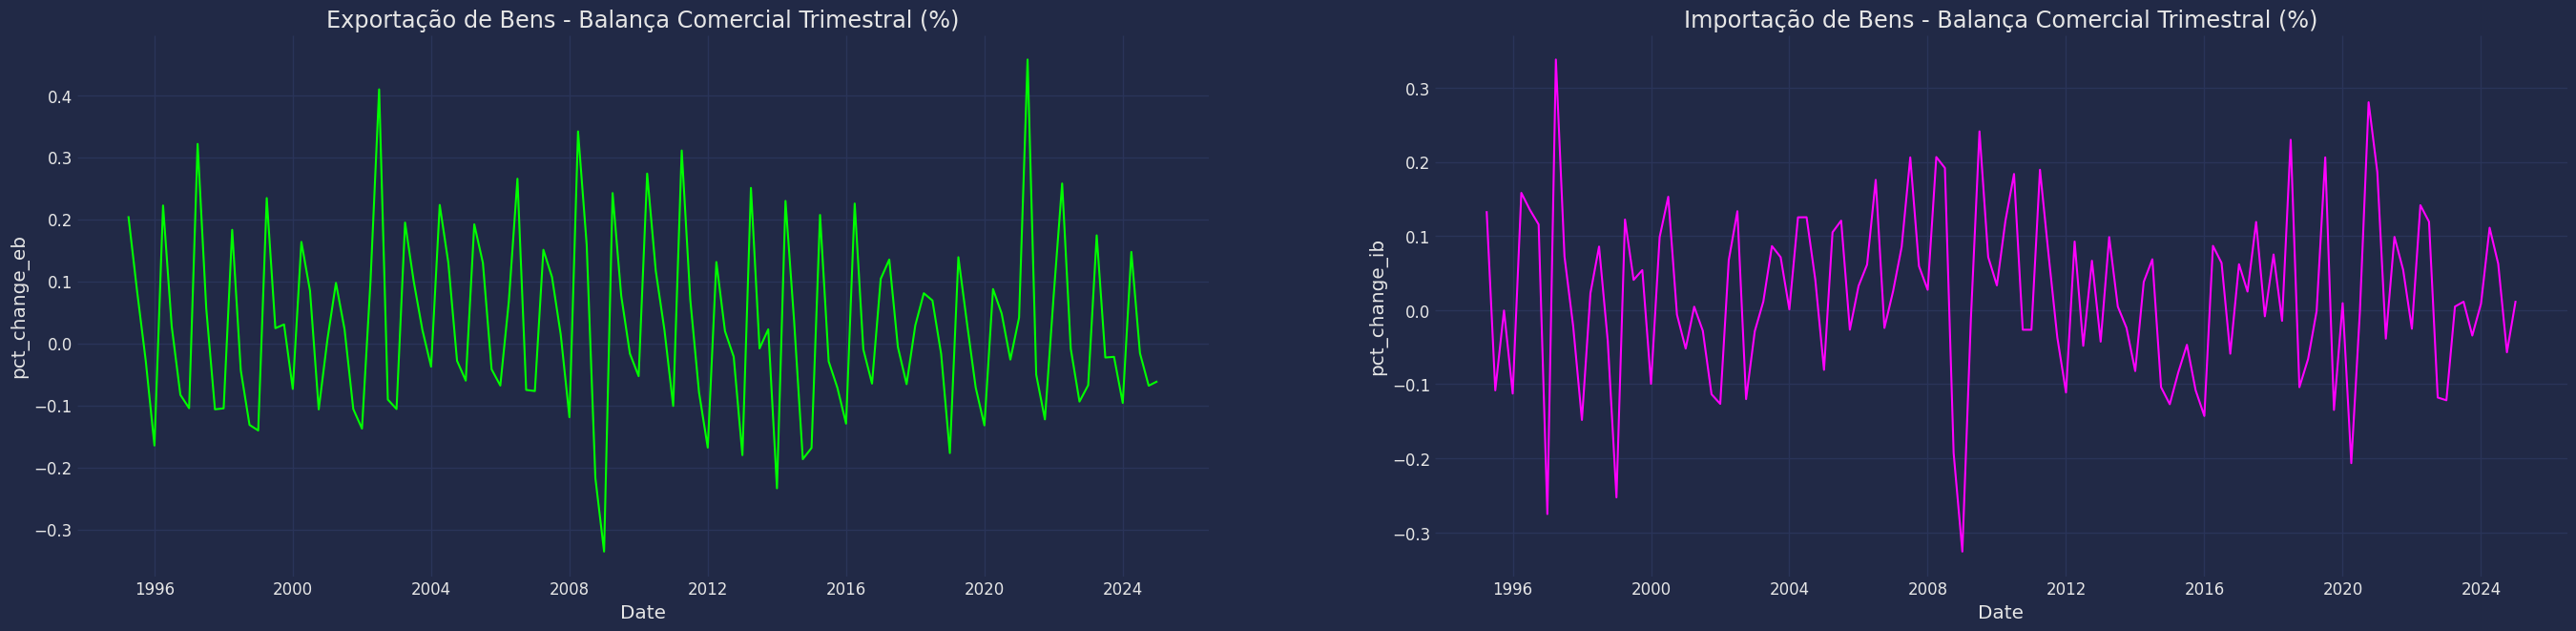

In [66]:
BALANCA_COMERCIAL_TRIMESTRAL = {
    'BALANCA_COMERCIAL': 23087,
    'EXPORTACAO_BENS': 23088,
    'IMPORTACAO_BENS': 23089
}

bc_tri = pd.DataFrame(sgs.get(BALANCA_COMERCIAL_TRIMESTRAL))
bc_tri['pct_change_bc'] = bc_tri['BALANCA_COMERCIAL'].pct_change()
bc_tri['pct_change_eb'] = bc_tri['EXPORTACAO_BENS'].pct_change()
bc_tri['pct_change_ib'] = bc_tri['IMPORTACAO_BENS'].pct_change()
bc_tri_not_float = bc_tri[['pct_change_eb', 'pct_change_ib']].round(2)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 7), sharex=True)

sns.lineplot(data=bc_tri, x=bc_tri.index, y='pct_change_eb', ax=axs[0], color='lime')
axs[0].set_title('Exportação de Bens - Balança Comercial Trimestral (%)')
sns.lineplot(data=bc_tri, x=bc_tri.index, y='pct_change_ib', ax=axs[1], color='fuchsia')
axs[1].set_title('Importação de Bens - Balança Comercial Trimestral (%)')

plt.show()

Autocorrelação entre os trimestres: 70.1518%


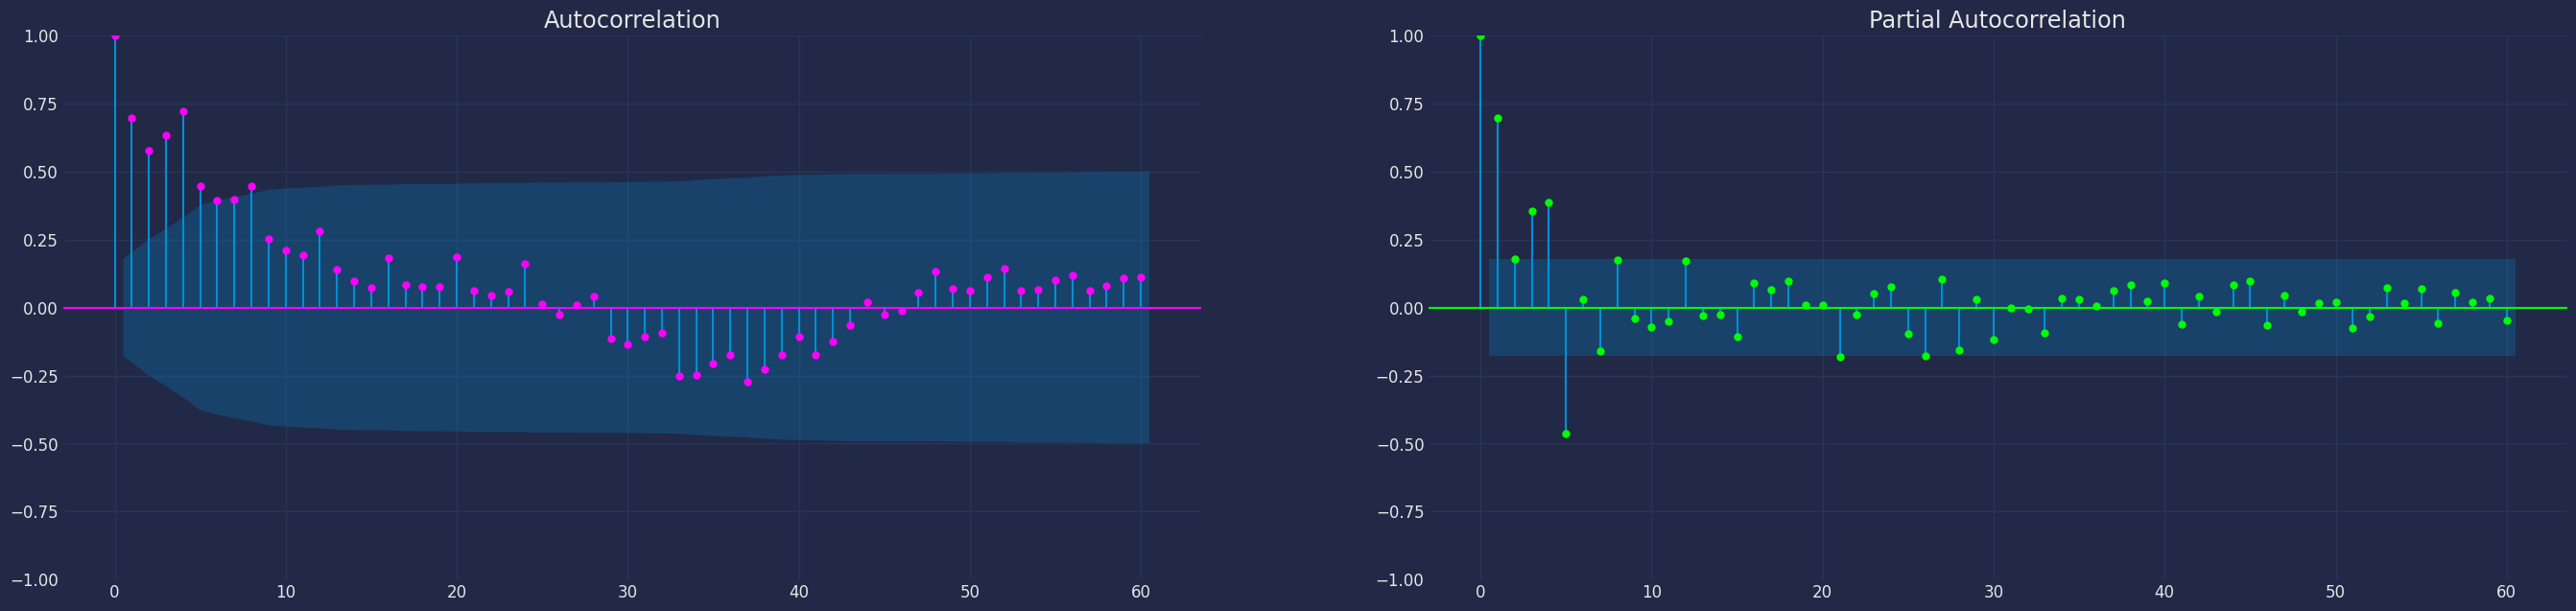

In [67]:
matplotlib.rcParams['figure.figsize'] = (30, 7)
bc = bc_tri['BALANCA_COMERCIAL'].reset_index()
bc.loc[:, 'lag1_bc'] = bc['BALANCA_COMERCIAL'].shift(1)
bc['Date'] = pd.to_datetime(bc['Date'])
bc.set_index('Date', inplace=True)

autocorr = bc['BALANCA_COMERCIAL'].autocorr(lag=1)
print(f"Autocorrelação entre os trimestres: {(np.round(autocorr, 6) * 100)}%")


fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(bc["BALANCA_COMERCIAL"],  lags=60, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation")

plot_pacf(bc["BALANCA_COMERCIAL"],  lags=60, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show()

**y(t)=Level∗Trend∗seasonality∗Noise**

* This formula represents a time series decomposition model where:
* y(t) - The observed value at time t.
* Level - The baseline level of the time series.
* Trend - The long-term progression or direction of the time series.
* Seasonality - The repeating patterns or cycles in the time series.
* Noise - The random variation or error component in the time series.
* The components are multiplicative, meaning the observed value is the product of these factors.

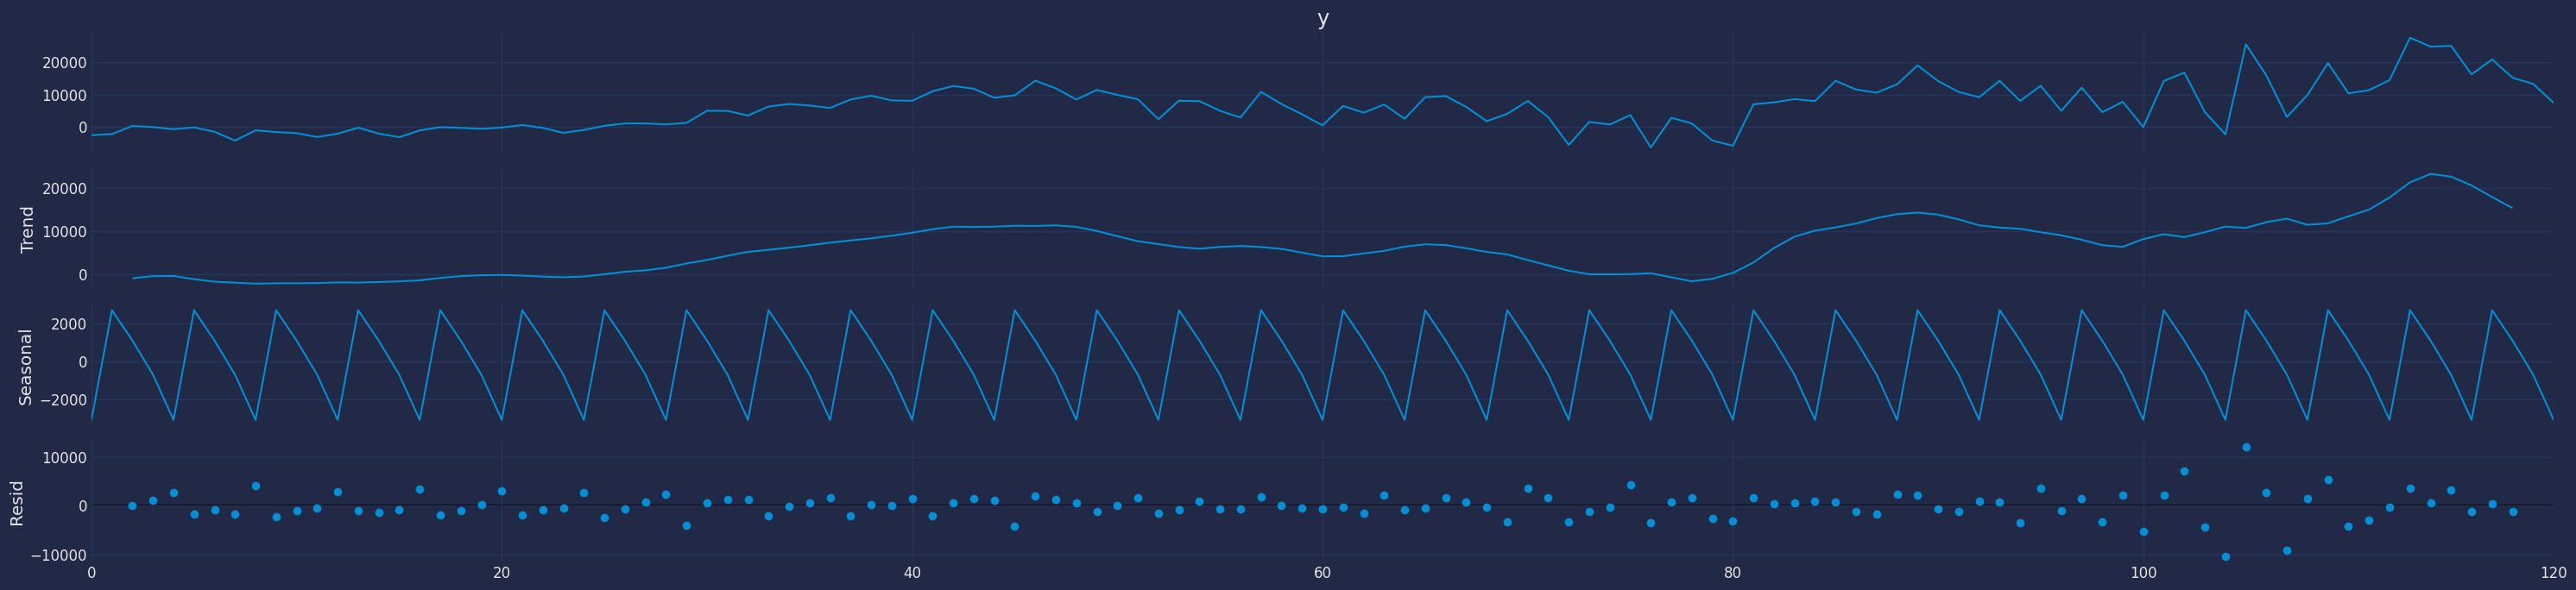

In [68]:
bc_df = (
    bc.reset_index()
    .assign(unique_id='bc')
    .rename(columns={'Date': 'ds', 'BALANCA_COMERCIAL': 'y'})
    .drop(columns=['lag1_bc'])
)

result = seasonal_decompose(bc_df['y'], model='add', period=4).plot()

models = [AutoARIMA(season_length=4, approximation=True)]
bc_df = bc_df[['unique_id', 'ds', 'y']].sort_values(by='ds')
sf = StatsForecast(
    models=models,
    freq='QE',
    n_jobs=-1
)

forecast_df = sf.forecast(df=bc_df, h=121, level=[95], fitted=True)

#adjust
insample_forecasts = sf.forecast_fitted_values().reset_index()

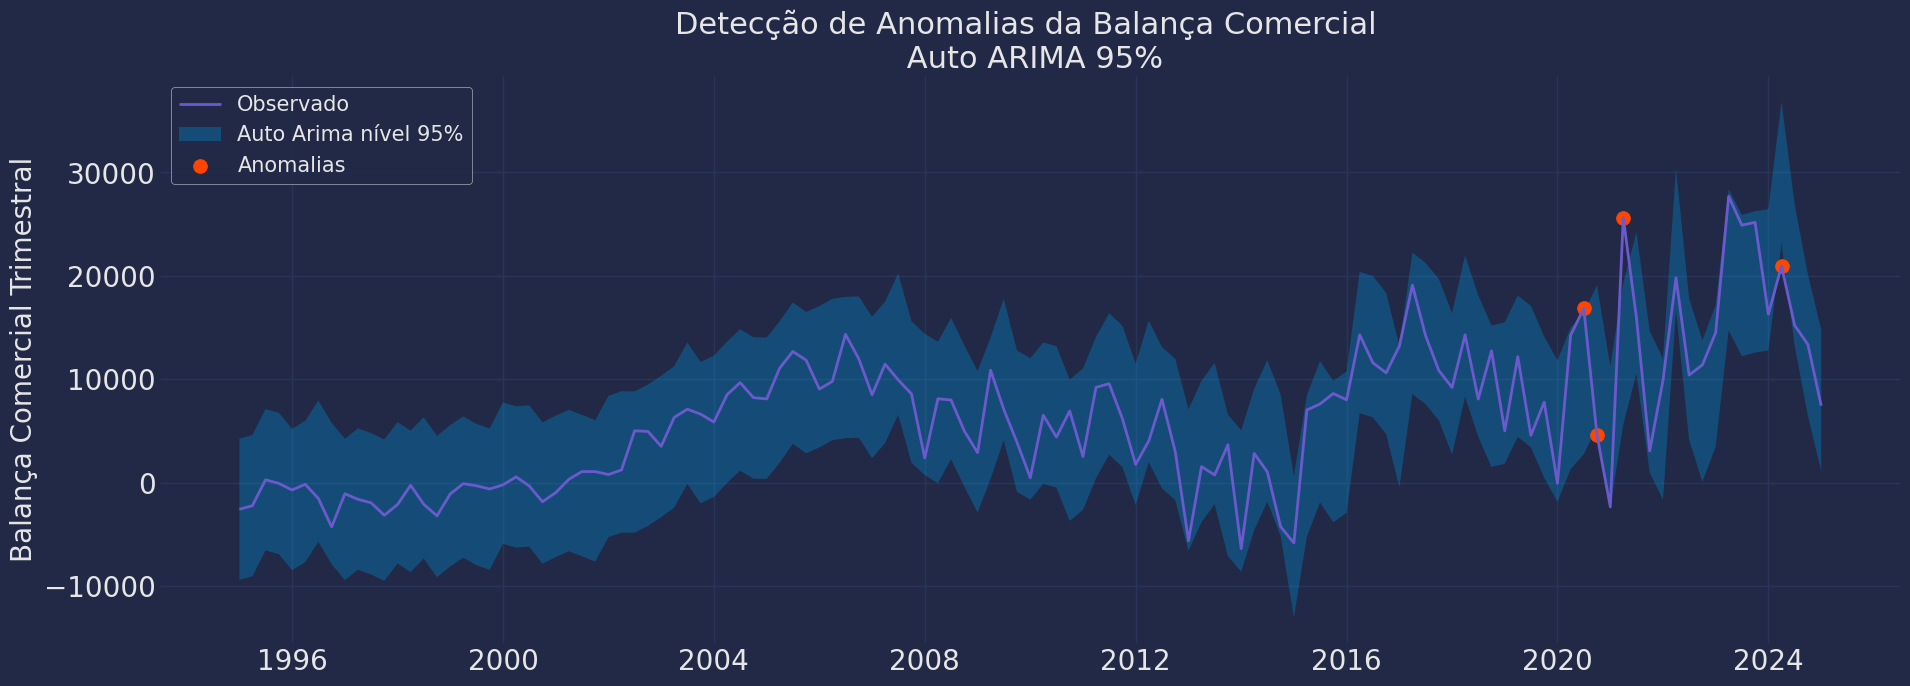

In [69]:
#plot graph
COLOR_GRAPHS_SLATEBLUE = 'slateblue'
COLOR_GRAPHS_ORANGERED = 'orangered'

fig, ax = plt.subplots(1,1, figsize=(20, 7))
ax.plot(insample_forecasts['ds'], 
        insample_forecasts['y'],
        linewidth=2, 
        label='Observado', 
        color=COLOR_GRAPHS_SLATEBLUE)

ax.fill_between(
    insample_forecasts['ds'],
    insample_forecasts['AutoARIMA-lo-95'],
    insample_forecasts['AutoARIMA-hi-95'],
    alpha = .35,
    label='Auto Arima nível 95%'
)

anomalies_df = insample_forecasts.query('y > `AutoARIMA-hi-95` or y < `AutoARIMA-lo-95`')[['ds', 'y']]
ax.scatter(
    anomalies_df['ds'], 
    anomalies_df['y'], 
    color=COLOR_GRAPHS_ORANGERED, 
    label='Anomalias',
    s=100
)

ax.set_title(f'Detecção de Anomalias da Balança Comercial \n Auto ARIMA 95%', fontsize=22)
ax.set_ylabel('Balança Comercial Trimestral', fontsize=20)
ax.legend(prop={'size': 15})
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
plt.show()

anomalies_insights = anomalies_df.copy()

(25, 3) (96, 3)


Text(0, 0.5, 'Balança Comercial Trimestral')

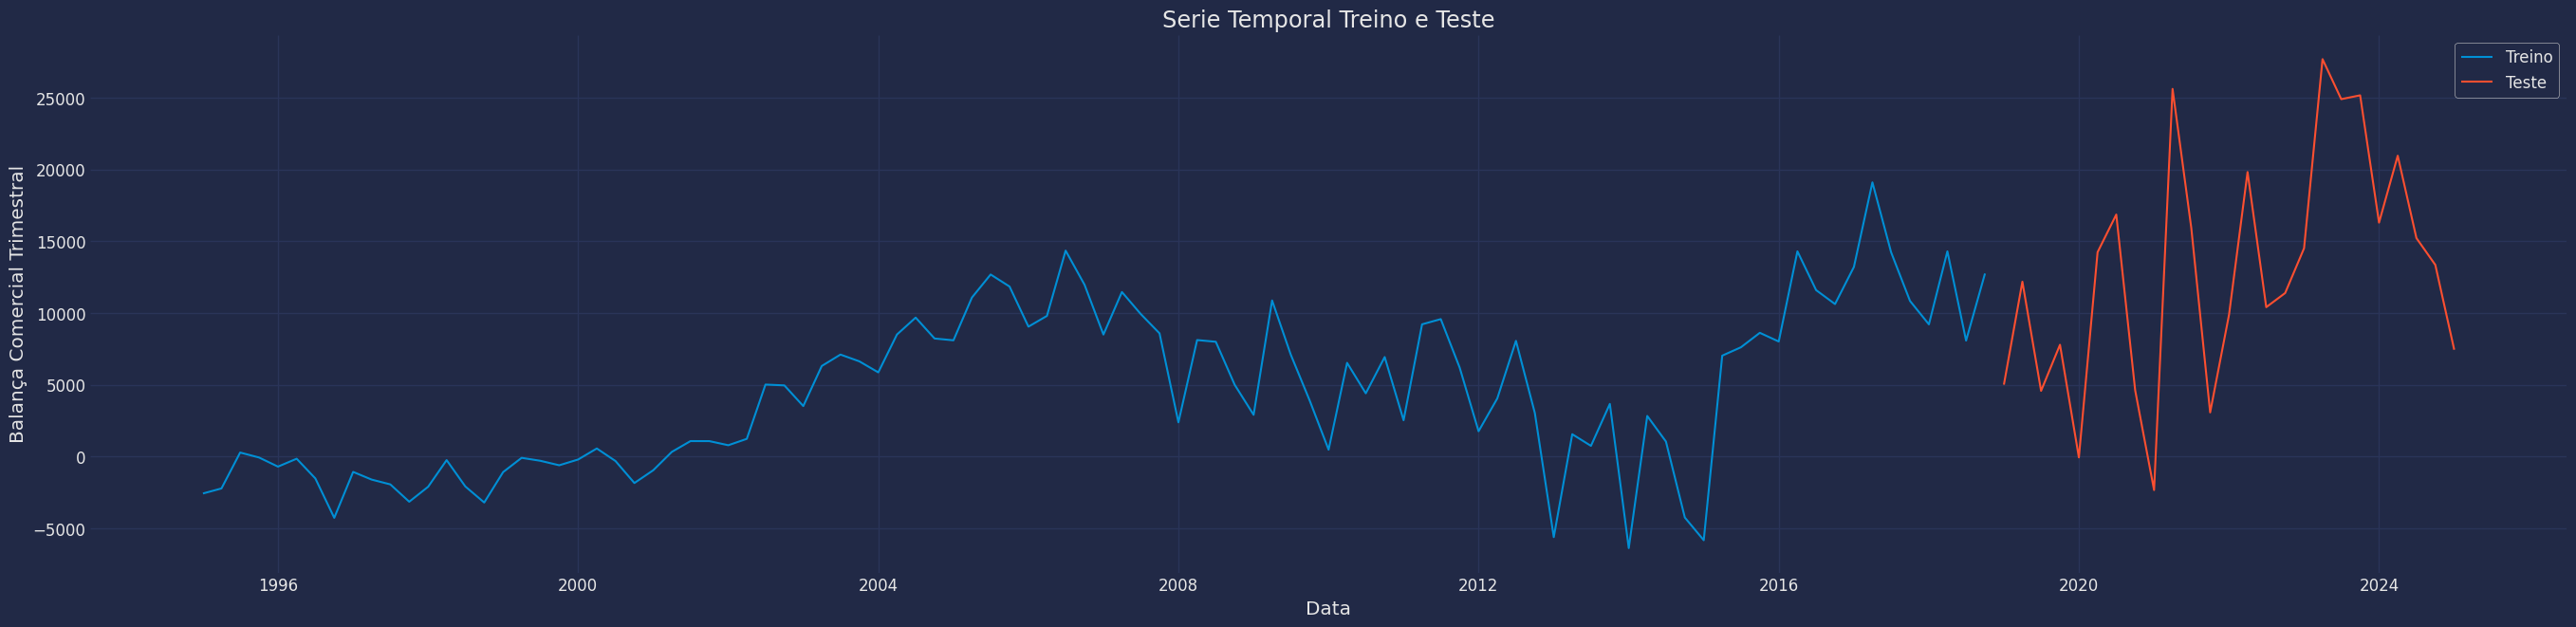

In [83]:
# training model 


split_index = int(len(bc_df) * 0.80)

Y_train_df = bc_df.iloc[:split_index]
Y_test_df = bc_df.iloc[split_index:]
print(Y_test_df.shape, Y_train_df.shape)
sns.lineplot(data=Y_train_df, x='ds', y='y', label='Treino')
sns.lineplot(data=Y_test_df, x='ds', y='y', label='Teste')
plt.title("Serie Temporal Treino e Teste")
plt.xlabel("Data")
plt.ylabel("Balança Comercial Trimestral")

In [84]:
seasson_length = 3
horizon = len(Y_test_df)

models = [AutoARIMA(season_length=seasson_length)]

sf = StatsForecast(
    models=models,
    freq='QE'
)

sf.fit(df=Y_train_df)

StatsForecast(models=[AutoARIMA])

In [85]:
StatsForecast(models=[AutoARIMA], freq='QE')

#choose better fit model to use in this time series data
arima_string(sf.fitted_[0,0].model_)

result=sf.fitted_[0,0].model_
print(result.keys())
print(result['arma']) #use cases


# look for the residual of the model

residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'xreg', 'bic', 'aicc', 'ic', 'x', 'lambda'])
(2, 2, 1, 1, 3, 1, 0)


,residual Model
0,-2.773835
1,103.387410
2,1680.616168
3,169.165174
4,123.391277
...,...
91,-2380.793203
92,-2230.349663
93,-964.388594
94,-4491.528866


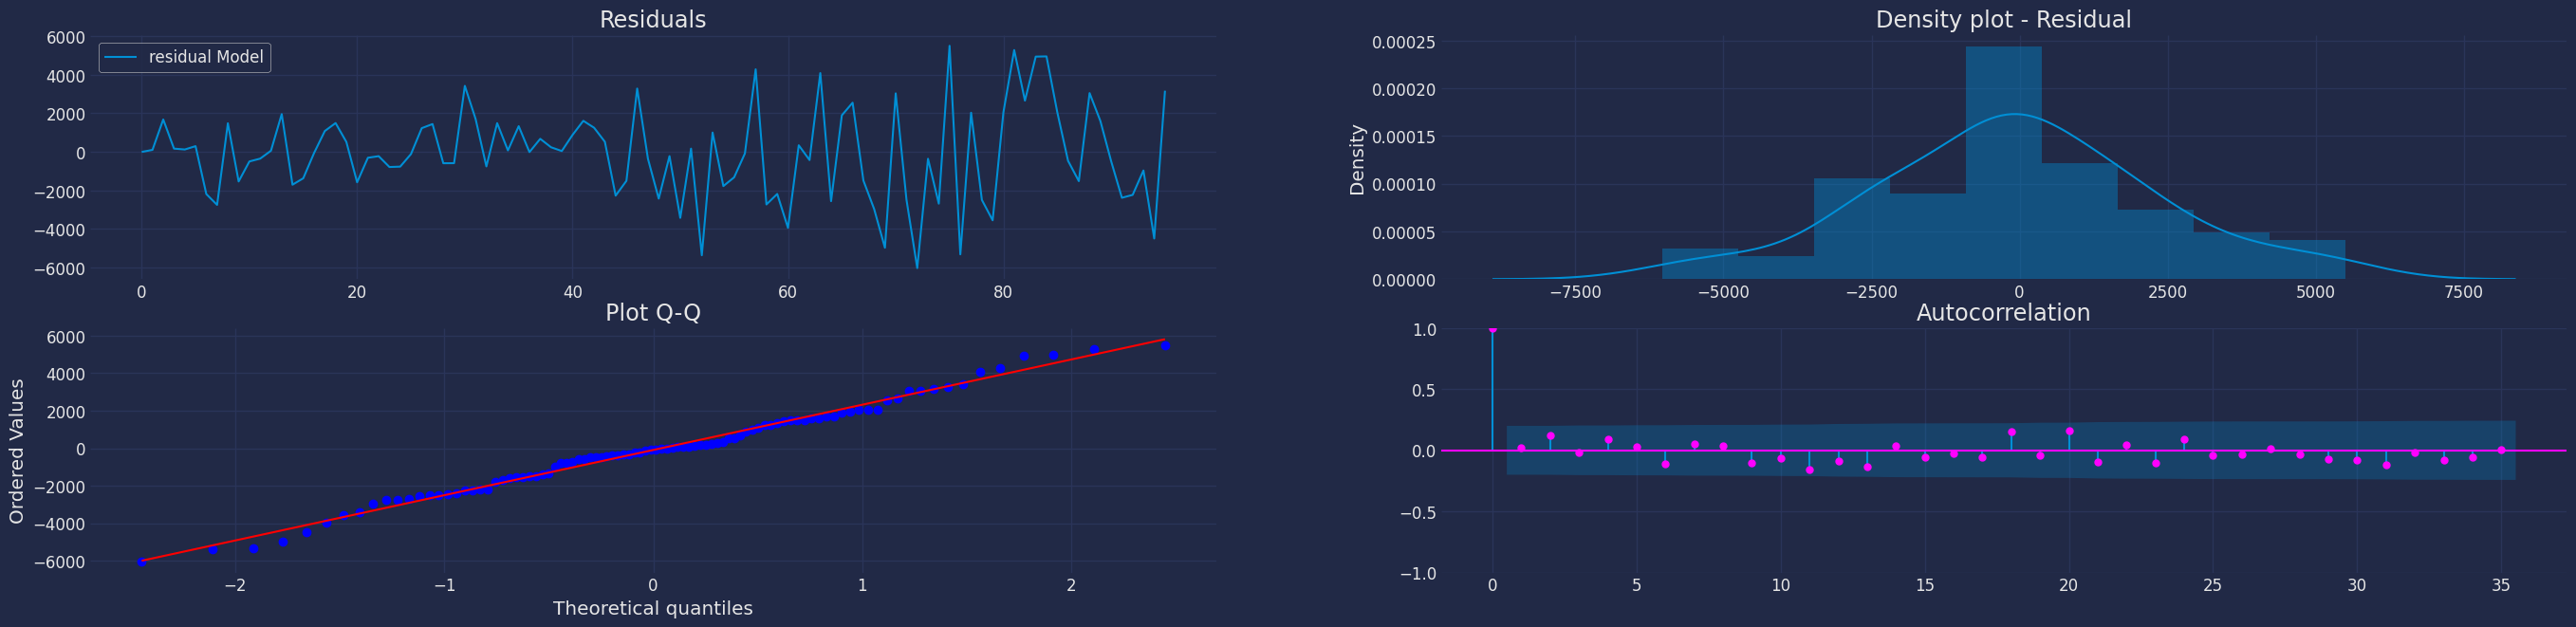

In [86]:
fig, axs = plt.subplots(nrows=2, ncols=2)

# plot[1,1]
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

# plot
sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show()

In [87]:
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon, fitted=True)
Y_hat_df

# adjust the date to the first day of the month
Y_hat_df['ds'] = pd.to_datetime(Y_hat_df['ds']) + pd.offsets.MonthBegin(1)

values=sf.forecast_fitted_values()
values

sf.forecast(df=Y_train_df, h=12, level=[95])

print(Y_hat_df.head())
print(Y_test_df.head())

  unique_id         ds     AutoARIMA
0        bc 2019-01-01  11555.509000
1        bc 2019-04-01  13421.934742
2        bc 2019-07-01   9351.664636
3        bc 2019-10-01  11811.266511
4        bc 2020-01-01  12150.765205
    unique_id         ds        y
96         bc 2019-01-01   5009.5
97         bc 2019-04-01  12187.5
98         bc 2019-07-01   4579.3
99         bc 2019-10-01   7791.0
100        bc 2020-01-01    -56.1


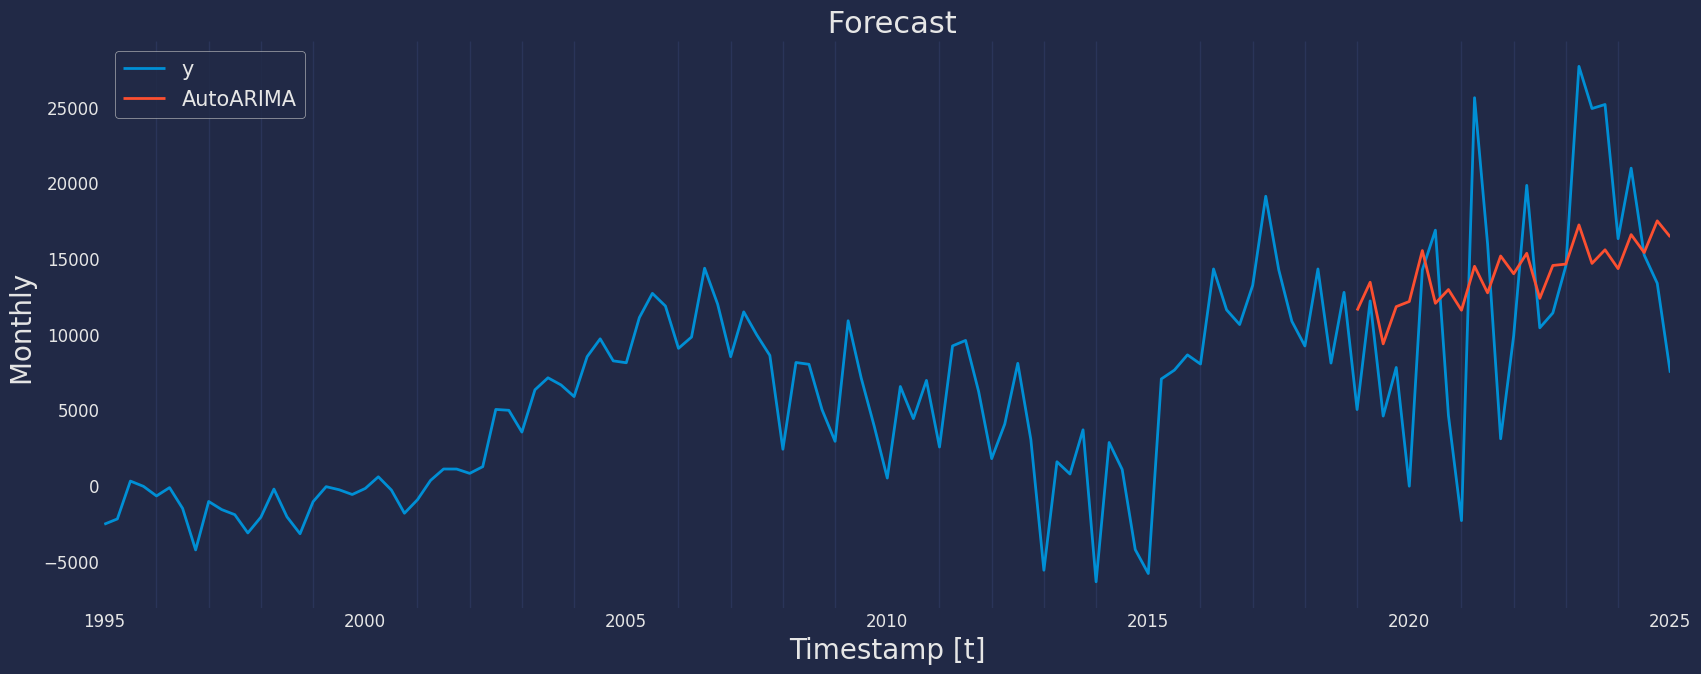

In [88]:
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
fig, ax = plt.subplots(1, 1, figsize = (18, 7))
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
plot_df[['y', 'AutoARIMA']].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Monthly ', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

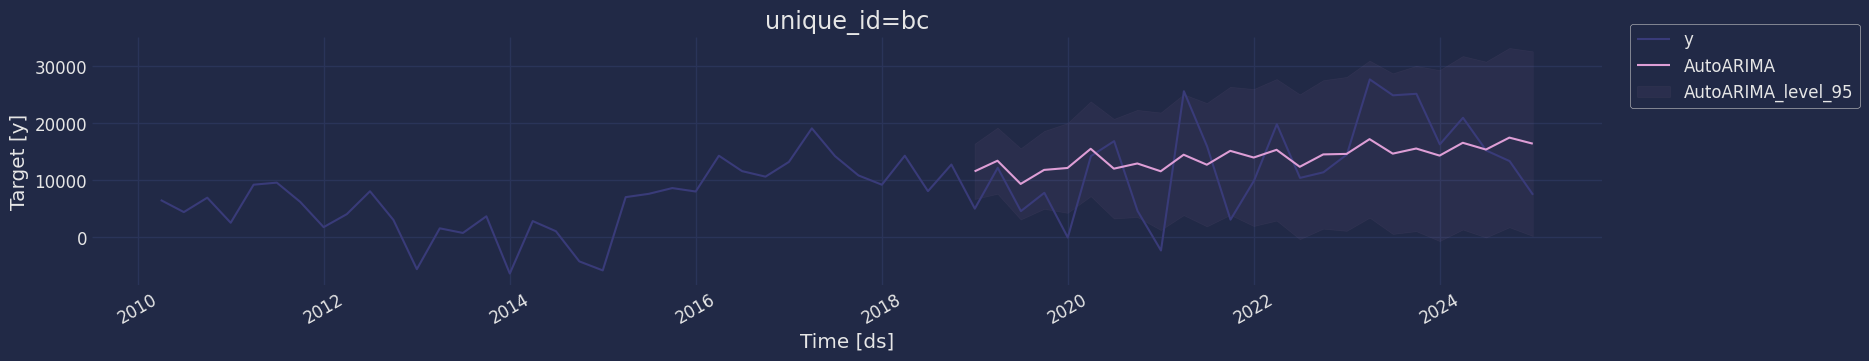

In [89]:
sf.predict(h=12)

forecast_df = sf.predict(h=horizon, level =[80, 95])
forecast_df

df_plot=pd.concat([bc_df, forecast_df]).set_index('ds').tail(220)
df_plot

sf.plot(bc_df, forecast_df, level=[95], max_insample_length=12 * 5)


In [81]:
crossvalidation_df = sf.cross_validation(df=Y_train_df,
                                         h=12,
                                         step_size=12,
                                         n_windows=5)

crossvalidation_df.head()


,unique_id,ds,cutoff,y,AutoARIMA
0,bc,2002-07-01,2002-04-01,5017.3,1235.0
1,bc,2002-10-01,2002-04-01,4960.1,1235.0
2,bc,2003-01-01,2002-04-01,3519.4,1235.0
3,bc,2003-04-01,2002-04-01,6313.0,1235.0
4,bc,2003-07-01,2002-04-01,7108.4,1235.0


In [82]:
from functools import partial

import utilsforecast.losses as ufl
from utilsforecast.evaluation import evaluate

evaluate(
    Y_test_df.merge(Y_hat_df),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=seasson_length), ufl.rmse, ufl.smape],
    train_df=Y_train_df,
)

,unique_id,metric,y_x,y_y,AutoARIMA
0,bc,mae,0.0,0.0,6301.377120
1,bc,mape,0.0,0.0,9.891722
2,bc,mase,0.0,0.0,2.056009
3,bc,rmse,0.0,0.0,7844.822051
4,bc,smape,0.0,0.0,0.261441
